# 02 - Introduction to seismic imaging

This notebook is the second in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this second example we aim to highlight the core ideas behind seismic inversion, where we create an image of the subsurface from field recorded data. This tutorial follows on the modelling tutorial and will reuse the modelling and velocity model.

## Imaging requirement

Seismic imaging relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is auired as described in the first tutorial. In order to siplify this tutorial we will fake field data by modelling it with the true velocity model.

- **Background velocity model**. This is a velocity model that has been obtained by processing and inverting the field data. We will look at this methods in the following tutorial as it relies on the method we are describing here. This velocity model is usually a smooth version of the true velocity model.

## Imaging computational setup

In this tutorial, we will introduce the back-propagation operator. This operator simulates the adjoint wave-equation, that is a wave-equation solved in a reversed time order. This time reversal led to the naming of the method we present here called Reverse Time Mogration. The notion of adjoint in exploration geophysics is fundamental as most of the wave-equation based imaging and inversion methods rely on adjoint based optimization methods.

## Notes on the operators.

As we already describe the creation of a forward modelling operator, we will only call an wraped function here. This wrapers already contains all the necessary operator for seismic modeling, imaging and inversion, however any new operator will be fully described and only used from the wrapper in the next tutorials.

In [1]:
# As we already saw the output of the code generation, we are turning
# of the logging to clean up the terminal due to a larger number of
# calls to the operators
from devito.logger import set_log_level
set_log_level('ERROR')

# True and smooth velocity models.

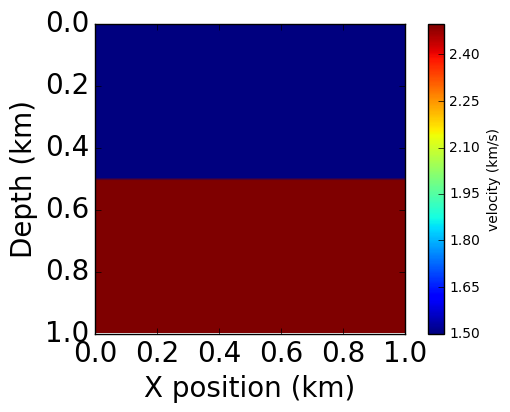

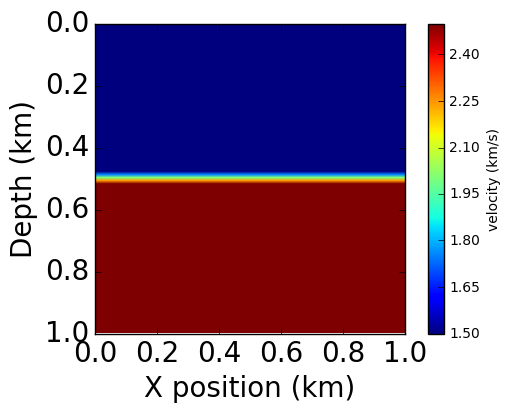

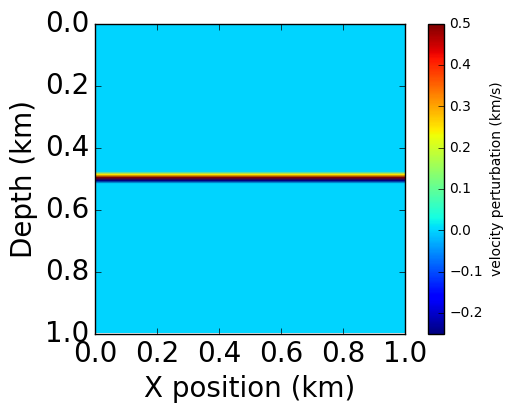

In [2]:
import numpy as np
from examples.seismic import plot_velocity, plot_perturbation
%matplotlib inline

# We import now the Model abstraction for seismic modeling
from examples.seismic import Model

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulate this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape,
              spacing=spacing, nbpml=20)

plot_velocity(model)

# We are now smoothing the velocity model

v_smooth = np.empty(shape, dtype=np.float32)
v_smooth[:, :48] = 1.5
v_smooth[:, 53:] = 2.5
for i in range(0, shape[0]):
    v_smooth[i, 48:53] = np.linspace(1.5, 2.5, 5)

# encapsulate this properties. We also define the size of the absorbing layer as 10 grid points
model0 = Model(vp=v_smooth, origin=origin, shape=shape,
               spacing=spacing, nbpml=20)

plot_velocity(model0)

plot_perturbation(model0, model)

# True and smooth data

We can now generate the shot record correspondingto both models. The difference between this two record will be the basis of the imaging procedure. The acquisition geometry is the same as in the previous tutorial.

In [3]:
# Acquisition geometry
from examples.seismic import PointSource, Receiver
t0 = 0.
tn = 1000.  # Simulation last 1 second (1000 ms)
f0 = 0.015  # Source peak frequency is 10Hz (0.010 kHz)

dt = model.critical_dt  # Computational time step. This value is obtained from
# the maximum velocity and the grid size and is defined with the CFL condition. This is the 
# numerical condition to ensure the discrete model is stable. We will define it properly
# later on but it is required here.
nt = int(1+(tn-t0)/dt)  # Discrete time axis length


# Source initalization for a single source
def Ricker(t, f0):
    r = (np.pi * f0 * (t - 1./f0))
    return (1 - 2.*r**2) * np.exp(-r**2)

src = PointSource(name='src', npoint=1, ntime=nt, ndim=2)
src.data[:, 0] = Ricker(np.linspace(t0, tn, nt), f0)

# Set location of the source
src.coordinates.data[0, 0] = origin[0] + shape[0] * spacing[0] * 0.5
src.coordinates.data[0, 1] = 30.

# Receiver initialization. This one does not contain any
# data as it will be computed during the simulation and correspond
# to the true model
true_d = Receiver(name='rec', npoint=101, ntime=nt, ndim=2)
true_d.coordinates.data[:, 0] = np.linspace(0, origin[0] + shape[0] * spacing[0], num=101)
true_d.coordinates.data[:, 1] = 30.

# Receiver initialization. This one does not contain any
# data as it will be computed during the simulation and correspond
# to the smooth model
smooth_d = Receiver(name='rec', npoint=101, ntime=nt, ndim=2)
smooth_d.coordinates.data[:, 0] = np.linspace(0, origin[0] + shape[0] * spacing[0], num=101)
smooth_d.coordinates.data[:, 1] = 30.

In [4]:
# Forward operator 
from examples.seismic.acoustic import AcousticWaveSolver
from devito.interfaces import TimeData

solver = AcousticWaveSolver(model, src, true_d, space_order=4)
solver.forward(src=src, rec=true_d, m=model.m)

(rec(time, p_rec),
 u(t, x, y),
 PerformanceSummary([('section_1',
                      PerfEntry(time=0.00011399999999999978, gflopss=0.21363157894736884, oi=0.7296860019175455, itershape=[594, 1], datashape=[596, 1])),
                     ('section_2',
                      PerfEntry(time=0.018638000000000043, gflopss=0.10622395106771089, oi=1.3703859060402686, itershape=[594, 101], datashape=[596, 101])),
                     ('main',
                      PerfEntry(time=0.04598999999999983, gflopss=5.575605088062643, oi=1.3525425843331582, itershape=[594, 137, 137], datashape=[596, 141, 141]))]))

In [5]:
# Smooth data
solver.forward(src=src, rec=smooth_d, m=model0.m)

(rec(time, p_rec),
 u(t, x, y),
 PerformanceSummary([('section_1',
                      PerfEntry(time=0.00011899999999999976, gflopss=0.20465546218487438, oi=0.7296860019175455, itershape=[594, 1], datashape=[596, 1])),
                     ('section_2',
                      PerfEntry(time=0.012078000000000047, gflopss=0.1639180327868846, oi=1.3703859060402686, itershape=[594, 101], datashape=[596, 101])),
                     ('main',
                      PerfEntry(time=0.03889999999999981, gflopss=6.591827197943477, oi=1.3525425843331582, itershape=[594, 137, 137], datashape=[596, 141, 141]))]))

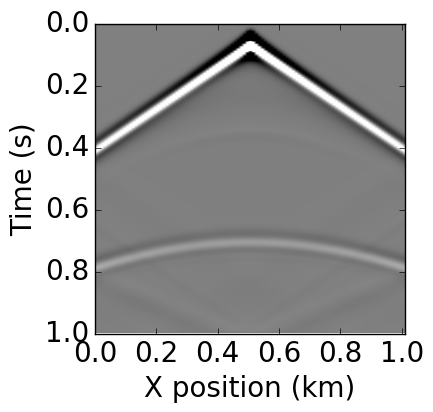

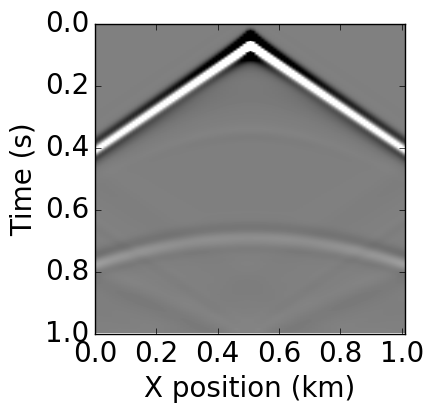

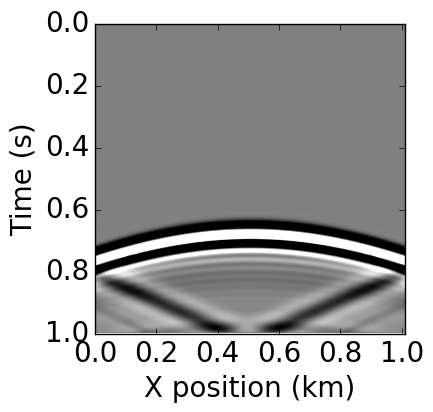

In [6]:
# Shot record for the true and smooth velocity model and the difference

from examples.seismic import plot_shotrecord

plot_shotrecord(true_d.data, origin, spacing, shape, t0, tn)

plot_shotrecord(smooth_d.data, origin, spacing, shape, t0, tn)

plot_shotrecord(smooth_d.data - true_d.data, origin, spacing, shape, t0, tn, diff=True)

The only difference between the smooth and the true velocity model is the value of the velocity. The dimensions of the model are unchanged. We can therefore reuse the forward modelling operator we just build and only specify the new velocity model, the shot record we want the result to be in and a new initialized wavefield.

If the shot record is not specified, the data will still be computed but will overwrite the true shot record. Concerning the initialization of a new wavefield, this comes from the simplified interface of this tutorial. In practice, a warapper would be built around the operator to reinitialize any field at runtime.

# Imaging with backpropagation

As we explained in the introduction of this tutorial, this method is based on backprobagation. 

## Adjoint wave equation

If we go back to the modelling part, we can rewrite the simulation as a linear system solve:

\begin{equation}
\mathbf{A}(\mathbf{m}) \mathbf{u} = \mathbf{q}
\end{equation}

where $\mathbf{m}$ is the discretized square slowness, $\mathbf{q}$ is the discretized source and $\mathbf{A}(mathbf{m})$ is the discretized wave-equation. The discretized wave-equation matricial representation is a lower triangular matrix that can be solve with forward subsitution. The pointwise writing ot the forward substitution leads to the time-stepping stencil.

On a small problem, and with a linear algebra software such as Matlab, one could form the matrix explicitly and transpose it to obtain the adjoint discrete wave-equation:

\begin{equation}
\mathbf{A}(\mathbf{m})^T \mathbf{v} = \delta \mathbf{d}
\end{equation}

where $\mathbf{v}$ is the discrete **adjoint wavefield** and  $\delta \mathbf{d}$ is the data residual defined as the difference between the field/observed data and the synthetic data $\mathbf{d}_s = \mathbf{P}_r \mathbf{u}$. In our case we derive the discrete adjoint wave-equation from the diiscfete forward wave-equation to get its stencil. 

## Imaging

Wave-equation based imaging relies on one simple concept.

- If the background velocity model is cinematically coorect, the forward wavefield $\mathbf{u}$ and the adjoint wavefield $\mathbf{v}$ meet at the reflectors position at zero time offset. 

The summ over time of the zero time-offset coorelation of this two fields creates then an image of the subsurface. Mathematically this eads to the simple imaging condition:

\begin{equation}
  \text{Image} = \sum_{t=1}^{n_t} \mathbf{u}[t] \mathbf{v}[t]
\end{equation}

We will describe in following tutorials more advanced imaging condition tha produces shaper/ more accurate results.

## Computational considerations

As we just explaine, the forward wave-equation is solved forward in time while the adjoint wave-equation is solved in a reversed time order. Therefor, the correlation of this two field over time requires to store one of the two fields. The computational workflow for imaging follows:

- Simulate the forward wave-equation with the background veocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the Image contribution at each time step. 

This workflo is applied to multiple source position and sumed to obatain the full image of the subsurface.

In [7]:
from devito import Backward, Operator
from devito import t, time, x, y

from sympy import solve, Eq


def image(model, rec, image):
    # Define the wavefield with the size of the model and the time dimension
    v = TimeData(name='vg', shape=model.shape_domain, time_order=2, space_order=4)

    u = TimeData(name='ug', shape=model.shape_domain, time_order=2, space_order=4,
                 save=True, time_dim=nt)
    # We can now write the PDE
    pde = model.m * v.dt2 - v.laplace - model.damp * v.dt

    # This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
    # Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as
    # a time marching updating equation known as a stencil using sympy functions

    stencil = Eq(v.backward, solve(pde, v.backward)[0])
    # Finally we define the source injection and receiver read function to generate the corresponding code
    src_term = rec.inject(field=v, expr=rec * model.critical_dt ** 2 / model.m,
                          u_t=t - 1, p_t=time, offset=model.nbpml)
    # Correlate the forward and adjoint wavefield for the current time step and add it to the image
    image_update = Eq(image, image - u * v)

    op = Operator([stencil] + src_term + [image_update],
                  subs={t.spacing: model.critical_dt, x.spacing: model.spacing[0],
                        y.spacing: model.spacing[1]},
                  time_axis=Backward)
    # Force compile the operator for simple reuse and correctness of the time axis
    return op

In [8]:
from devito.interfaces import DenseData
# Number of sources
nsrc = 21
sources = np.linspace(0, 1000, num=nsrc)

In [9]:
# Initialize a data residual object
# to the smooth model
residual = Receiver(name='recd', npoint=101, ntime=nt, ndim=2)
residual.coordinates.data[:, 0] = np.linspace(0, origin[0] + shape[0] * spacing[0], num=101)
residual.coordinates.data[:, 1] = 30.

# Gradient operator
Im = DenseData(name='Im', shape=model.shape_domain, dtype=model.m.dtype)
Imaging = image(model, residual, Im)
for i in range(0, nsrc):
    location = np.zeros((1, 2))
    location[0, 0] = sources[i]
    location[0, 1] = 30.
    src.coordinates.data[:] = location[:]
    # True data
    solver.forward(src=src, rec=true_d, m=model.m)
    # Smooth data (and save u0)
    smooth_d, u0, _ = solver.forward(src=src, rec=smooth_d, m=model0.m, save=True)
    # gradient 
    residual.data[:] = smooth_d.data[:] - true_d.data[:]
    v = TimeData(name='v', shape=model.shape_domain, time_order=2, space_order=4)
    Imaging(ug=u0, vg=v, m=model0.m, recd=residual)

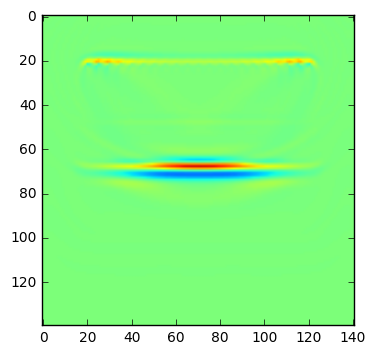

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(np.diff(np.transpose(Im.data[:, :]), axis=0), vmin=-1e5, vmax=1e5)

And we have an image of the subsurface with a strong reflector at the original location.